# Choice Set space for Neural Data

 The idea is to create a choice set that: samples the same SV difference (+ - some variation) with different trials.
 - 5 different SV deltas, including 0.   

In [229]:
#Import the relevant libraries
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
#pd.options.display.max_rows = 999
#pd.options.display.max_columns = 999

# 1. Input: 
- Patient's RAW data

- Parameters from the utility model

In [230]:
#path= 'Z:/Santiago_Guardo/data' #Specify where the data is stored in the FileShare. This is for my Laptop

#Path to the data files
path = '/Volumes/UCDN/datasets/ICR' #MAC path to the File share
patient_code = 'patient1_calibration' #Specify the patient's code
patient_split_dir = os.path.join(path,'split') 
patient_trials = os.path.join(patient_split_dir,'{}/crdm/{}_crdm.csv').format(patient_code,patient_code) #This is the psychopy output CSV

#Path to the utility model data
utility_dir = os.path.join(path,'utility')
utility_analysis = os.path.join(utility_dir,'split_CRDM_analysis.csv')
parameters = pd.read_csv(utility_analysis)

print('loading fn: {}'.format(patient_trials))
print('loading fn: {}'.format(utility_analysis))

loading fn: /Volumes/UCDN/datasets/ICR/split/patient1_calibration/crdm/patient1_calibration_crdm.csv
loading fn: /Volumes/UCDN/datasets/ICR/utility/split_CRDM_analysis.csv


In [231]:
#Declare the variables we are going to be using

trials = pd.read_csv(patient_trials)
p_options = trials['crdm_lott_p'].unique()/100
p_options = p_options[~np.isnan(p_options)]  # Remove nan values ~is a logical NOT operator
p_options = p_options.tolist()  # Do we want p_options to be an array or a list? Ask Ricardo 
p_options = sorted(p_options, reverse=True)
amb_options = [0.24, 0.5, 0.74]

#Declare the variables


# A= df['crdm_amb_lev'].values[0] #Ambiguity level
A_null = 0.0 # no ambiguity
Vmax = 50.0 #The maximum amount we can pay to participants
Vmin = -50.0 #The minimum amount we can take from participants
Vsafe_pos = 5.0 # The old safe option in positive trials
Vsafe_neg = -5.0 # The old safe option in negative trials

# used for populating trials
empty_df = pd.DataFrame([],columns=['category','p_reward', 'value_reward'])

p_options 


[0.75, 0.5, 0.38, 0.25, 0.13]

# 2. Running the model and plotting it

In [232]:

#From the CRDM_analysis CSV we pick our patient's parameters
filtered_parameters = parameters[parameters['subject'] == patient_code]

# Create pos, comb, neg parameters and read them from the csv
alpha_pos = filtered_parameters.loc[filtered_parameters['domain'] == 'gain', 'alpha'].values[0]
alpha_comb = filtered_parameters.loc[filtered_parameters['domain'] == 'combined', 'alpha'].values[0]
alpha_neg = filtered_parameters.loc[filtered_parameters['domain'] == 'loss', 'alpha'].values[0]


beta_pos = filtered_parameters.loc[filtered_parameters['domain'] == 'gain', 'beta'].values[0]
beta_comb = filtered_parameters.loc[filtered_parameters['domain'] == 'combined', 'beta'].values[0]
beta_neg = filtered_parameters.loc[filtered_parameters['domain'] == 'loss', 'beta'].values[0]


print("alpha_pos:", alpha_pos)
print("alpha_combined:", alpha_comb)
print("alpha_neg:", alpha_neg)

print("\nbeta_pos:", beta_pos)
print("beta_combined:", beta_comb)
print("beta_pos:", beta_neg)



alpha_pos: 0.125
alpha_combined: 0.9555108189143096
alpha_neg: 0.5420177337405991

beta_pos: 0.2748311397972592
beta_combined: 0.617126793788233
beta_pos: -1.177300190736865


In [233]:
def plot_sv(alpha, beta, trials = 'gains'): #Define a function to plot SV given participant's input
    A = 0 
    p_options = [1.0, 0.87, 0.75, 0.62, 0.5, 0.38, 0.25, 0.13] #We want a line for every probability level. The 1.0 is the classic (non risky) utility function
    
    v = np.linspace(0, 50, 100) # The x axis goes from 0 to 50 an takes 100 points (just to make the figure smooth
    if trials == 'losses':
        v = np.linspace(0, -50, 100)
    plt.figure(figsize=(10, 6)) #Create a plot figure
    Amp = 1.0
    if trials == 'losses':
        Amp = -1.0
    for p in p_options: #Iterate through each probability level
        sv = (p - beta * A / 2)* Amp * abs(v)**alpha #Calculate the SV of every V from 0 to 50 for a given p
        if p == 1.0:  #Non risky 
            plt.plot(v, sv, label=f'p = {p}', linestyle='--', color='black') #If p=0, plot a black dashed line using V as X and SV as Y
        else:
            plt.plot(v, sv, label=f'p = {p}')

    plt.xlabel('Value of Reward')
    plt.ylabel('SV')
    plt.title("Participant's SV model for {}".format(trials))
    plt.legend()
    plt.grid(True)
    plt.show()



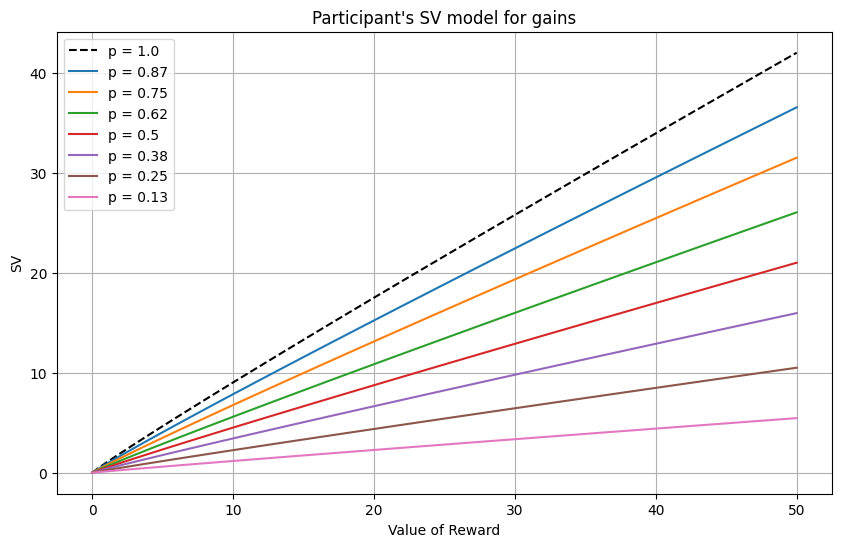

In [234]:
plot_sv(alpha_comb,beta_comb, trials = 'gains')

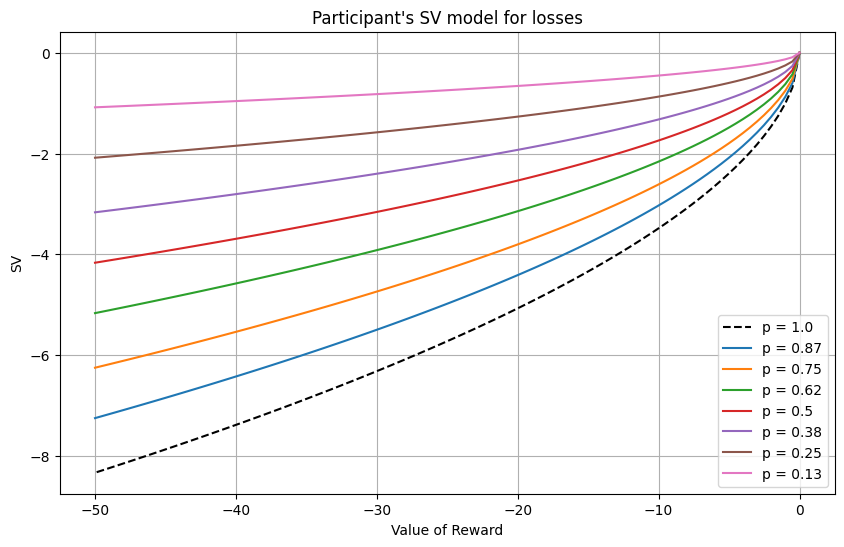

In [235]:
plot_sv(alpha_neg,beta_neg, trials = 'losses')

# 3. Creating the choice set

- 5 different SV deltas, including 0.
- Max SV delta
    - Winning or loosing $50 for each probability level
    - 


- Min SV delta: subjective equality trials. 

- 3 Intermediate trials. 


In [236]:
#Create the extreme positive gains and losses

def get_extreme(p_options,trials='gains'):
    extr = {} #Create an empty dict
    V = Vmax
    if trials=='losses': #If trials are losses, assign them -50
        V = Vmin
    for p in p_options: #Iterate through the probability levels
        extr[p] = V #Assign them the 50 dollars value
    return extr

extrpos = get_extreme(p_options)

extrneg = get_extreme(p_options,trials='losses')

#From the dictionaries, we create DataFrames to work with
def get_extr_df(extr_dict,trials='gains'):
    df_app = pd.DataFrame(extr_dict.items(), columns=['p_reward', 'value_reward'])
    Extr_df = pd.concat([empty_df, df_app], ignore_index=True)
    category = 'Extr_pos'
    if trials=='losses':
        category = 'Extr_neg'
    Extr_df['category'] = category
    Extr_df['ambiguity'] = A_null
    return Extr_df

def add_ambig_extr(df,amb_options,Vmax=50,prob_amb=0.50,trials='gains'):
    amb_dict = {prob_amb:amb_options}
    df_app = pd.DataFrame(amb_dict.items(), columns=['p_reward', 'ambiguity'])
    df_app = df_app.explode('ambiguity')
    df_app['category'] = df['category']
    df_app['value_reward'] = Vmax
    df = pd.concat([df,df_app],ignore_index=True)
    return df

# df_app = pd.DataFrame(centrials_neg.items(), columns=['p_reward', 'value_reward'])
# df_app = df_app.explode('value_reward')


#We define a function to calculate the SV of the trials given the 
#participant's alpha and beta

def append_SVreward(df,alpha,beta,trials='gains'):
    Amp = 1.0
    if trials == 'losses':
        Amp = -1.0
    df['SV_reward'] = (df['p_reward'] - beta*df['ambiguity']/2)*Amp*(abs(df['value_reward']))**alpha
    return df

#We define a function to calculate the SV of the safe options of the trials given the 
#participant's alpha and beta

def append_Vsafe(df,alpha,beta,trials='gains'): 
    Amp = 1.0
    if trials == 'losses':
        Amp = -1.0
    df['SV_New_Safe'] = 0.5*df['SV_reward']
    df['value_lott_SE'] = Amp*(abs(df['SV_New_Safe']) / (df['p_reward']-beta*df['ambiguity']/2)) ** (1 / alpha)
    df['value_safe'] = Amp*(abs(df['SV_New_Safe'])) ** (1 / alpha)
    return df

#Define the data frames
df_pos = get_extr_df(extrpos)
df_pos = add_ambig_extr(df_pos,amb_options)

df_neg = get_extr_df(extrneg,trials='losses')
df_neg = add_ambig_extr(df_neg,amb_options,Vmax=Vmin,trials='losses')


#Add the SV of reward and safe trials
df_pos = append_SVreward(df_pos,alpha_comb,beta_comb)
df_neg = append_SVreward(df_neg,alpha_neg,beta_neg,trials='losses')

df_pos = append_Vsafe(df_pos,alpha_comb,beta_comb)
df_neg = append_Vsafe(df_neg,alpha_neg,beta_neg,trials='losses')


In [237]:
df_pos

,category,p_reward,value_reward,ambiguity,SV_reward,SV_New_Safe,value_lott_SE,value_safe
0,Extr_pos,0.75,50.0,0.0,31.509788,15.754894,24.206047,17.912982
1,Extr_pos,0.50,50.0,0.0,21.006525,10.503263,24.206047,11.718654
2,Extr_pos,0.38,50.0,0.0,15.964959,7.98248,24.206047,8.793098
3,Extr_pos,0.25,50.0,0.0,10.503263,5.251631,24.206047,5.673246
4,Extr_pos,0.13,50.0,0.0,5.461697,2.730848,24.206047,2.861619
5,Extr_pos,0.50,50.0,0.24,17.89524,8.94762,24.206047,9.908767
6,Extr_pos,0.50,50.0,0.5,14.524681,7.26234,24.206047,7.96469
7,Extr_pos,0.50,50.0,0.74,11.413395,5.706698,24.206047,6.188745


In [249]:
df_pos1 = df_pos[['p_reward','ambiguity','SV_New_Safe','value_lott_SE','value_safe']].copy()
#for index, row in df_pos1.iterrows:
##    df_pos1['value_reward'] = (abs(SV) / (df_pos1['p_reward']-beta_comb*df_pos1['ambiguity']/2)) ** (1 / alpha_comb)
df_pos1

,p_reward,ambiguity,SV_New_Safe,value_lott_SE,value_safe
0,0.75,0.0,15.754894,24.206047,17.912982
1,0.50,0.0,10.503263,24.206047,11.718654
2,0.38,0.0,7.98248,24.206047,8.793098
3,0.25,0.0,5.251631,24.206047,5.673246
4,0.13,0.0,2.730848,24.206047,2.861619
5,0.50,0.24,8.94762,24.206047,9.908767
6,0.50,0.5,7.26234,24.206047,7.96469
7,0.50,0.74,5.706698,24.206047,6.188745


In [248]:
p_options = [0.75, 0.5, 0.38, 0.25, 0.13]
#alpha_comb = 0.9555108189143096
#beta_comb = 0.617126793788233
def calculate_value_reward(df, alpha, beta):
    new_rows = []
    
    for index,row in df.iterrows(): #loop to go through each row in the input DataFrame (df)
                                # and extract the relevant values to calculate value_reward
        SV = row['SV_New_Safe']  #The SV of the given row
        value_safe = row['value_safe'] #To keep value_safe constant
        for p in p_options:
            A = row['ambiguity'] 
            if A!= 0:
                p=0.50
            value_reward = (SV/(p-beta*A/2))**(1/alpha)
            new_rows.append({'SV_New_Safe': SV, 'p_reward': p, 'ambiguity':A, 'value_safe': value_safe, 'value_reward': value_reward}) 
            #All the calculated values are used to create a new dictionary for each combination.
            #The dictionaries are collected in a new rows list. 
            new_df = pd.DataFrame(new_rows,columns=['p_reward','ambiguity', 'value_reward', 'SV_New_Safe', 'value_safe']) #A new DF from the list
            new_df = new_df.round(2) 
    return new_df

calculate_value_reward(df_pos1, alpha_comb, beta_comb)



,p_reward,ambiguity,value_reward,SV_New_Safe,value_safe
0,0.75,0.00,24.21,15.75,17.91
1,0.50,0.00,37.00,15.75,17.91
2,0.38,0.00,49.31,15.75,17.91
3,0.25,0.00,76.43,15.75,17.91
4,0.13,0.00,151.52,15.75,17.91
5,0.75,0.00,15.84,10.50,11.72
6,0.50,0.00,24.21,10.50,11.72
7,0.38,0.00,32.26,10.50,11.72
8,0.25,0.00,50.00,10.50,11.72
9,0.13,0.00,99.13,10.50,11.72


In [242]:
df_neg

,category,p_reward,value_reward,ambiguity,SV_reward,SV_New_Safe,value_lott_SE,value_safe
0,Extr_neg,0.75,-50.0,0.0,-6.250764,-3.125382,-13.918175,-8.186072
1,Extr_neg,0.50,-50.0,0.0,-4.167176,-2.083588,-13.918175,-3.874312
2,Extr_neg,0.38,-50.0,0.0,-3.167054,-1.583527,-13.918175,-2.335074
3,Extr_neg,0.25,-50.0,0.0,-2.083588,-1.041794,-13.918175,-1.078467
4,Extr_neg,0.13,-50.0,0.0,-1.083466,-0.541733,-13.918175,-0.322734
5,Extr_neg,0.50,-50.0,0.24,-5.344621,-2.67231,-13.918175,-6.131806
6,Extr_neg,0.50,-50.0,0.5,-6.620185,-3.310093,-13.918175,-9.100877
7,Extr_neg,0.50,-50.0,0.74,-7.797629,-3.898815,-13.918175,-12.309654


# 4. Concat the DataFrames 

In [243]:
df_Trials_gains = pd.concat([df_pos],ignore_index=True)
df_Trials_gains['SV_New_Safe'] = df_Trials_gains['value_safe']**alpha_pos
df_Trials_gains['deltaSV'] = df_Trials_gains['SV_reward'] - df_Trials_gains['SV_New_Safe']
df_Trials_gains = df_Trials_gains.drop(columns=['value_lott_SE'])
# df_Trials_gains = df_Trials_gains.round(2)
df_Trials_gains

,category,p_reward,value_reward,ambiguity,SV_reward,SV_New_Safe,value_safe,deltaSV
0,Extr_pos,0.75,50.0,0.0,31.509788,1.43432,17.912982,30.075468
1,Extr_pos,0.50,50.0,0.0,21.006525,1.360222,11.718654,19.646304
2,Extr_pos,0.38,50.0,0.0,15.964959,1.312254,8.793098,14.652706
3,Extr_pos,0.25,50.0,0.0,10.503263,1.242307,5.673246,9.260956
4,Extr_pos,0.13,50.0,0.0,5.461697,1.140451,2.861619,4.321246
5,Extr_pos,0.50,50.0,0.24,17.89524,1.331995,9.908767,16.563245
6,Extr_pos,0.50,50.0,0.5,14.524681,1.296123,7.96469,13.228558
7,Extr_pos,0.50,50.0,0.74,11.413395,1.255886,6.188745,10.157509


In [244]:
df_Trials_losses = pd.concat([df_neg,df_cent_neg, df_int_neg],ignore_index=True)
df_Trials_losses['SV_New_Safe'] = -abs(df_Trials_gains['value_safe'])**alpha_pos
df_Trials_losses['deltaSV'] = df_Trials_losses['SV_reward'] - df_Trials_losses['SV_New_Safe']
df_Trials_losses = df_Trials_losses.drop(columns=['value_lott_SE'])
# df_Trials_losses = df_Trials_losses.round(2)
df_Trials_losses

NameError: name 'df_cent_neg' is not defined

# 5. Making sure it works. 
A.k.a Sanity check 

In [245]:
from matplotlib.gridspec import GridSpec
import sys

def scatter_hist(x, y, ax, ax_histy,xlabel='',ylabel='',title=''): #This functions creates a scatter plot with histograms at its sides
	#ax.scatter(x, y)
	ax.set_xlabel(xlabel,fontsize=12) #Creates the subplots
	ax.set_ylabel(ylabel,fontsize=12)
	plt.suptitle(title,fontsize=16, ha='center')
	#ax_histx.hist(x,bins=20)
	ax_histy.hist(y, bins=20)
	ax_histy.set_xlabel('SV Difference')
	ax_histy.set_ylabel('Number of trials')
	plt.tight_layout()


def setup_fig_ax():  #Setting the axis

	fig = plt.figure(figsize=(8.5,8.5))
	gs = GridSpec(4, 3)

	ax = fig.add_subplot(gs[1:4, 0:3])
	ax_histy = fig.add_subplot(gs[0,0:3])
	#ax_histx = fig.add_subplot(gs[1:4, 3])
	#ax_histx.tick_params(axis="x", labelbottom=False)
	ax_histy.tick_params(axis="y")
 	
	#Adjust spacing around subplots
	#plt.subplots_adjust(top=1.4, bottom=0.15, left=0.15, right=0.9)
	
	return ax, ax_histy

def plot_scatter_hist(df,xvline=50,trials='gains'):

	# delta SV v.s value_reward
	x,y = df['value_reward'],df['deltaSV'] 
	ax,ax_histy = setup_fig_ax()

	scatter_hist(x,y,ax,ax_histy,  
		xlabel='Value of Reward',
		ylabel= 'SV difference',
		title= 'SV difference v.s value of Reward {}'.format(trials))

	colors = ['r','g','b','c','y','m','k']
	amb_line = ['--','-.',':']
	df = df.sort_values('value_reward')

	for i,p in enumerate(reversed(sorted(df['p_reward'].unique()))): #A scatter plot for each probability level
		df_p = df.loc[(df['p_reward']==p) & (df['ambiguity']==A_null)]
		x,y = df_p['value_reward'],df_p['deltaSV']
		ax.plot(x, y,'{}o-'.format(colors[i]),label='prob={0:0.2f}'.format(p)) #The plot conecting prob levels
		if p==0.50:
			for j,A in enumerate(reversed(sorted(df['ambiguity'].unique()))):
				if A==0:
					continue
				df_A = df.loc[(df['p_reward']==p) & (df['ambiguity']==A)]
				x,y = df_A['value_reward'],df_A['deltaSV']
				ax.plot(x, y,'{0}o{1}'.format(colors[i],amb_line[j]),label='amb={0:0.2f}'.format(A)) #The plot conecting prob levels
				
		

	# ax.plot([50],[],'r-')
	ax.axvline(x=xvline)
	# ax.plot([-50,-50],[-10,10],'r-')
	ax.axhline(y=0)
	# ax.plot([0,50],[0,0],'k--')
	ax.legend(loc="upper left")


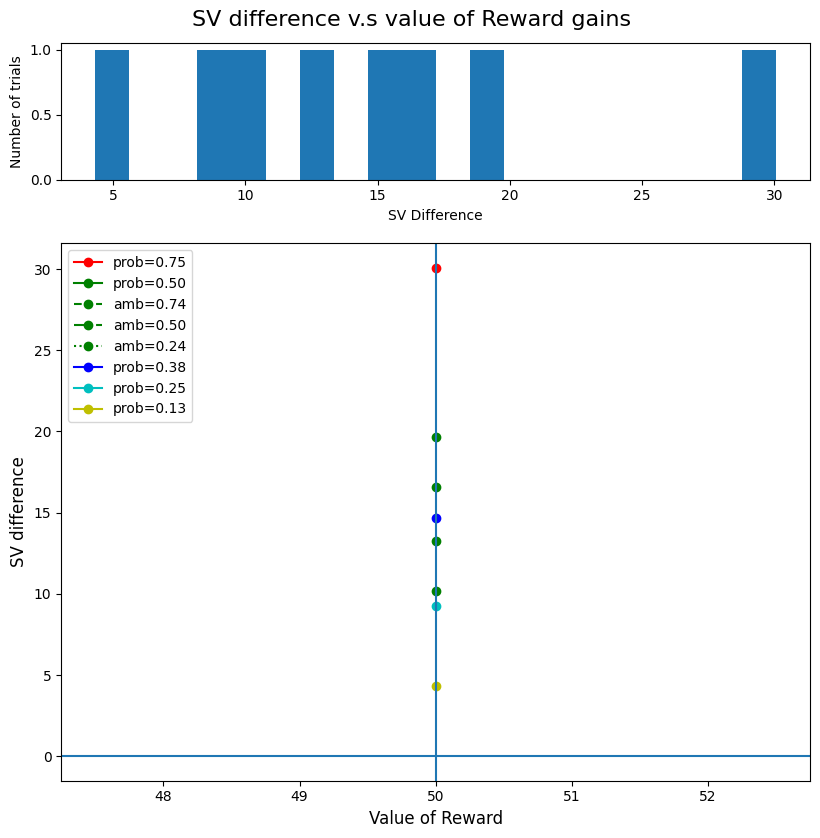

In [246]:
plot_scatter_hist(df_Trials_gains,xvline=50)